<a href="https://colab.research.google.com/github/hm-sharma/RedBus-Hackathon_project/blob/main/Redbus_Hackathon(h_m).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

In [6]:
transactions=pd.read_csv('/content/transactions.csv')

In [7]:
transactions.head(10)

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8.0,76.0,30
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8.0,70.0,30
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4.0,142.0,30
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0.0,68.0,30
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,162.0,30
5,2023-03-01,2023-01-30,9,46,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,0.0,63.0,30
6,2023-03-01,2023-01-30,46,48,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,0.0,309.0,30
7,2023-03-01,2023-01-30,48,46,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,0.0,165.0,30
8,2023-03-01,2023-01-30,45,9,Karnataka,Tamil Nadu,Tier 1,Tier2,3.0,84.0,30
9,2023-03-01,2023-01-30,9,45,Tamil Nadu,Karnataka,Tier2,Tier 1,0.0,39.0,30


In [8]:
df_test=pd.read_csv('/content/test_8gqdJqH.csv')

In [9]:
df_test.head()

,route_key,doj,srcid,destid
0,2025-02-11_46_45,2025-02-11,46,45
1,2025-01-20_17_23,2025-01-20,17,23
2,2025-01-08_02_14,2025-01-08,2,14
3,2025-01-08_08_47,2025-01-08,8,47
4,2025-01-08_09_46,2025-01-08,9,46


In [10]:
train=pd.read_csv('/content/train.csv')

In [11]:
train.head()

,doj,srcid,destid,final_seatcount
0,2023-03-01,45,46,2838.0
1,2023-03-01,46,45,2298.0
2,2023-03-01,45,47,2720.0
3,2023-03-01,47,45,2580.0
4,2023-03-01,46,9,4185.0


To train the model we'll need these features.


## Route and City features

In [12]:

# Filter transactions to only include records where days_before_departure >= 15
transactions_filtered = transactions[transactions['dbd'] >= 15].copy()

# Aggregate latest city-level info as of 15 days before journey
route_city_features = transactions_filtered.groupby(['srcid', 'destid', 'doj']).agg({
    'srcid_region': 'last',
    'destid_region': 'last',
    'srcid_tier': 'last',
    'destid_tier': 'last'
}).reset_index()


## 2. Temporal Features

In [13]:
train['doj'] = pd.to_datetime(train['doj'])

train['day_of_week'] = train['doj'].dt.dayofweek  # Monday=0
train['month'] = train['doj'].dt.month

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=train['doj'].min(), end=train['doj'].max())
train['is_holiday'] = train['doj'].isin(holidays).astype(int)

train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)  # Saturday=5, Sunday=6


## 3. Transactional and Behavioral Features

In [14]:
# Aggregate max cumulative seats and searches up to 15 days before journey
agg_features = transactions_filtered.groupby(['srcid', 'destid', 'doj']).agg({
    'cumsum_seatcount': 'max',
    'cumsum_searchcount': 'max'
}).reset_index()

# Helper function to get cumulative values at specific days before journey
def get_cumulative_at_day(df, day):
    return df[df['dbd'] == day][['srcid', 'destid', 'doj', 'cumsum_seatcount', 'cumsum_searchcount']]

cum_15 = get_cumulative_at_day(transactions, 15)
cum_22 = get_cumulative_at_day(transactions, 22)

# Calculate booking and search velocity between day 22 and day 15
velocity = pd.merge(cum_15, cum_22, on=['srcid', 'destid', 'doj'], suffixes=('_15', '_22'))
velocity['booking_velocity_7d'] = velocity['cumsum_seatcount_15'] - velocity['cumsum_seatcount_22']
velocity['search_velocity_7d'] = velocity['cumsum_searchcount_15'] - velocity['cumsum_searchcount_22']
# Merge velocity with aggregated features
features = pd.merge(agg_features, velocity[['srcid', 'destid', 'doj', 'booking_velocity_7d', 'search_velocity_7d']], on=['srcid', 'destid', 'doj'], how='left')

# Calculate search to booking ratio, fill NaN with 0
features['search_to_booking_ratio'] = features['cumsum_seatcount'] / features['cumsum_searchcount']
features['search_to_booking_ratio'] = features['search_to_booking_ratio'].fillna(0)


## 4. Historical demand features

In [15]:
# Convert date_of_journey to datetime
train['doj'] = pd.to_datetime(train['doj'], errors='coerce')

# Aggregate average and median demand per route
route_stats = train.groupby(['srcid', 'destid']).agg(
    avg_historical_demand=('final_seatcount', 'mean'),
    median_historical_demand=('final_seatcount', 'median'),
    route_popularity=('final_seatcount', 'count')
).reset_index()

# Average demand by day of week per route
dow_stats = train.groupby(['srcid', 'destid', train['doj'].dt.dayofweek]).agg(
    avg_demand_dow=('final_seatcount', 'mean')
).reset_index().rename(columns={'doj': 'day_of_week'})

# Add day_of_week to train
train['day_of_week'] = train['doj'].dt.dayofweek

# Merge route_stats and dow_stats with train
train = train.merge(route_stats, on=['srcid', 'destid'], how='left')
train = train.merge(dow_stats, on=['srcid', 'destid', 'day_of_week'], how='left')


## 5. Holiday Deamand Boost

In [16]:
# Using the is_holiday flag already created in train
holiday_demand = train.groupby(['srcid', 'destid', 'is_holiday']).agg(
    avg_demand=('final_seatcount', 'mean')
).reset_index()

# Separate holiday and non-holiday averages
holiday_avg = holiday_demand[holiday_demand['is_holiday'] == 1][['srcid', 'destid', 'avg_demand']].rename(columns={'avg_demand': 'holiday_avg'})
non_holiday_avg = holiday_demand[holiday_demand['is_holiday'] == 0][['srcid', 'destid', 'avg_demand']].rename(columns={'avg_demand': 'non_holiday_avg'})

# Merge and compute boost ratio
holiday_boost = pd.merge(holiday_avg, non_holiday_avg, on=['srcid', 'destid'])
holiday_boost['holiday_demand_boost'] = holiday_boost['holiday_avg'] / holiday_boost['non_holiday_avg']

# Merge with train
train = train.merge(holiday_boost[['srcid', 'destid', 'holiday_demand_boost']], on=['srcid', 'destid'], how='left')


## 6. Days since last Journey

In [17]:
train = train.sort_values(['srcid', 'destid', 'doj'])
train['days_since_last_journey'] = train.groupby(['srcid', 'destid'])['doj'].diff().dt.days


## Merging all the features into a single data frame


In [18]:

from functools import reduce

def merge_feature_dataframes(route_city_features, features, train):
    train_subset = train[[
    'srcid', 'destid', 'doj', 'day_of_week', 'month', 'is_holiday', 'is_weekend',
    'avg_historical_demand', 'median_historical_demand', 'avg_demand_dow',
    'route_popularity', 'holiday_demand_boost', 'days_since_last_journey', 'final_seatcount'
]]

    df_list = [route_city_features, features, train_subset]

    final_train_df = reduce(
        lambda left, right: pd.merge(left, right, on=['srcid', 'destid', 'doj'], how='left'),
        df_list
    )

    return final_train_df


# Usage example (assuming the dataframes are already prepared):
# final_train_df = merge_feature_dataframes(route_city_features, features, train)
# print(final_train_df.head())


In [19]:
route_city_features['doj'] = pd.to_datetime(route_city_features['doj'])
features['doj'] = pd.to_datetime(features['doj'])
train['doj'] = pd.to_datetime(train['doj'])

final_train_df = merge_feature_dataframes(route_city_features, features, train)
print(final_train_df.head())

   srcid  destid        doj         srcid_region        destid_region  \
0      1       2 2023-03-01  Maharashtra and Goa  Maharashtra and Goa   
1      1       2 2023-03-02  Maharashtra and Goa  Maharashtra and Goa   
2      1       2 2023-03-03  Maharashtra and Goa  Maharashtra and Goa   
3      1       2 2023-03-04  Maharashtra and Goa  Maharashtra and Goa   
4      1       2 2023-03-05  Maharashtra and Goa  Maharashtra and Goa   

  srcid_tier destid_tier  cumsum_seatcount  cumsum_searchcount  \
0      Tier2      Tier 1               0.0                90.0   
1      Tier2      Tier 1               0.0                75.0   
2      Tier2      Tier 1               0.0                75.0   
3      Tier2      Tier 1               0.0                65.0   
4      Tier2      Tier 1               0.0                80.0   

   booking_velocity_7d  ...  month  is_holiday  is_weekend  \
0                  0.0  ...    3.0         0.0         0.0   
1                  0.0  ...    3.0      

In [20]:
final_train_df

,srcid,destid,doj,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,booking_velocity_7d,...,month,is_holiday,is_weekend,avg_historical_demand,median_historical_demand,avg_demand_dow,route_popularity,holiday_demand_boost,days_since_last_journey,final_seatcount
0,1,2,2023-03-01,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,90.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1201.979167,672.0,1.016572,NaN,1115.0
1,1,2,2023-03-02,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,75.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1153.958333,672.0,1.016572,1.0,1040.0
2,1,2,2023-03-03,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,75.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1271.510417,672.0,1.016572,1.0,935.0
3,1,2,2023-03-04,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,65.0,0.0,...,3.0,0.0,1.0,1304.010417,1282.5,1278.906250,672.0,1.016572,1.0,1170.0
4,1,2,2023-03-05,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,80.0,0.0,...,3.0,0.0,1.0,1304.010417,1282.5,1572.760417,672.0,1.016572,1.0,1480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,48,46,2025-02-24,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,51.0,2517.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73096,48,46,2025-02-25,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,27.0,2094.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73097,48,46,2025-02-26,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,84.0,3432.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73098,48,46,2025-02-27,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,396.0,11871.0,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   srcid                     73100 non-null  int64         
 1   destid                    73100 non-null  int64         
 2   doj                       73100 non-null  datetime64[ns]
 3   srcid_region              73100 non-null  object        
 4   destid_region             73100 non-null  object        
 5   srcid_tier                73100 non-null  object        
 6   destid_tier               73100 non-null  object        
 7   cumsum_seatcount          73100 non-null  float64       
 8   cumsum_searchcount        73100 non-null  float64       
 9   booking_velocity_7d       73100 non-null  float64       
 10  search_velocity_7d        73100 non-null  float64       
 11  search_to_booking_ratio   73100 non-null  float64       
 12  day_of_week       

In [22]:
print(final_train_df.isna().sum().sum())


65000


In [23]:
print(final_train_df.isna().sum())



srcid                          0
destid                         0
doj                            0
srcid_region                   0
destid_region                  0
srcid_tier                     0
destid_tier                    0
cumsum_seatcount               0
cumsum_searchcount             0
booking_velocity_7d            0
search_velocity_7d             0
search_to_booking_ratio        0
day_of_week                 5900
month                       5900
is_holiday                  5900
is_weekend                  5900
avg_historical_demand       5900
median_historical_demand    5900
avg_demand_dow              5900
route_popularity            5900
holiday_demand_boost        5900
days_since_last_journey     6000
final_seatcount             5900
dtype: int64


In [24]:
# Check total missing values per column
missing_counts = final_train_df.isnull().sum()

# Display columns with missing values
print(missing_counts[missing_counts > 0])


day_of_week                 5900
month                       5900
is_holiday                  5900
is_weekend                  5900
avg_historical_demand       5900
median_historical_demand    5900
avg_demand_dow              5900
route_popularity            5900
holiday_demand_boost        5900
days_since_last_journey     6000
final_seatcount             5900
dtype: int64


In [25]:
final_train_df = final_train_df.dropna(subset=['final_seatcount'])
print(f"After dropping missing targets, dataset shape: {final_train_df.shape}")


After dropping missing targets, dataset shape: (67200, 23)


## imputing missing values in historial demand features

In [26]:
hist_features = [
    'avg_historical_demand', 'median_historical_demand', 'avg_demand_dow',
    'route_popularity', 'holiday_demand_boost'
]

for col in hist_features:
    median_val = final_train_df[col].median()
    final_train_df[col].fillna(median_val, inplace=True)


/tmp/ipython-input-26-2551916680.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_train_df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-26-2551916680.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_df[col].fillna(median_val, inplace=True)


In [27]:
print(final_train_df.isnull().sum())



srcid                         0
destid                        0
doj                           0
srcid_region                  0
destid_region                 0
srcid_tier                    0
destid_tier                   0
cumsum_seatcount              0
cumsum_searchcount            0
booking_velocity_7d           0
search_velocity_7d            0
search_to_booking_ratio       0
day_of_week                   0
month                         0
is_holiday                    0
is_weekend                    0
avg_historical_demand         0
median_historical_demand      0
avg_demand_dow                0
route_popularity              0
holiday_demand_boost          0
days_since_last_journey     100
final_seatcount               0
dtype: int64


In [28]:
final_train_df.head(10)

,srcid,destid,doj,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,booking_velocity_7d,...,month,is_holiday,is_weekend,avg_historical_demand,median_historical_demand,avg_demand_dow,route_popularity,holiday_demand_boost,days_since_last_journey,final_seatcount
0,1,2,2023-03-01,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,90.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1201.979167,672.0,1.016572,NaN,1115.0
1,1,2,2023-03-02,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,75.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1153.958333,672.0,1.016572,1.0,1040.0
2,1,2,2023-03-03,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,75.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1271.510417,672.0,1.016572,1.0,935.0
3,1,2,2023-03-04,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,65.0,0.0,...,3.0,0.0,1.0,1304.010417,1282.5,1278.906250,672.0,1.016572,1.0,1170.0
4,1,2,2023-03-05,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,80.0,0.0,...,3.0,0.0,1.0,1304.010417,1282.5,1572.760417,672.0,1.016572,1.0,1480.0
5,1,2,2023-03-06,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,55.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1350.625000,672.0,1.016572,1.0,745.0
6,1,2,2023-03-07,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,110.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1298.333333,672.0,1.016572,1.0,1355.0
7,1,2,2023-03-08,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,180.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1201.979167,672.0,1.016572,1.0,1240.0
8,1,2,2023-03-09,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,5.0,130.0,5.0,...,3.0,0.0,0.0,1304.010417,1282.5,1153.958333,672.0,1.016572,1.0,1230.0
9,1,2,2023-03-10,Maharashtra and Goa,Maharashtra and Goa,Tier2,Tier 1,0.0,90.0,0.0,...,3.0,0.0,0.0,1304.010417,1282.5,1271.510417,672.0,1.016572,1.0,1120.0


## finding cuttoff date for splitting data set

In [63]:
cutoff_date = final_train_df['doj'].quantile(0.7)  # approximately 80% date

print(f"Using cutoff date: {cutoff_date}")


Using cutoff date: 2024-06-13 00:00:00


In [30]:
print("Date range in dataset:")
print(f"Min date: {final_train_df['doj'].min()}")
print(f"Max date: {final_train_df['doj'].max()}")


Date range in dataset:
Min date: 2023-03-01 00:00:00
Max date: 2024-12-31 00:00:00


## spliting data into test and train

In [64]:
# Ensure 'doj' is datetime type
final_train_df['doj'] = pd.to_datetime(final_train_df['doj'])

# Define cutoff date
cutoff_date = '2024-06-13'
train_data = final_train_df[final_train_df['doj'] < cutoff_date]
val_data = final_train_df[final_train_df['doj'] >= cutoff_date]

# Separate features and target
target_col = 'final_seatcount'
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]
X_val = val_data.drop(columns=[target_col])
y_val = val_data[target_col]

# Drop identifier columns
drop_cols = ['srcid', 'destid', 'doj']
X_train = X_train.drop(columns=drop_cols)
X_val = X_val.drop(columns=drop_cols)

# --- NEW CODE: PREPARE CATEGORICAL FEATURES ---
categorical_features = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')



/tmp/ipython-input-64-1849519644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_df['doj'] = pd.to_datetime(final_train_df['doj'])


## training model

In [65]:
model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    random_state=42
)

# Use callbacks for early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)],
    categorical_feature=categorical_features
)

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 47000, number of used features: 18
[LightGBM] [Info] Start training from score 1921.975830
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 614.447	valid_0's l2: 377545
[100]	valid_0's rmse: 569.638	valid_0's l2: 324487
[150]	valid_0's rmse: 561.588	valid_0's l2: 315381
[200]	valid_0's rmse: 557.242	valid_0's l2: 310519
[250]	valid_0's rmse: 555.091	valid_0's l2: 308126
[300]	valid_0's rmse: 553.882	valid_0's l2: 306785
[350]	valid_0's rmse: 552.618	valid_0's l2: 305387
[400]	valid_0's rmse: 552.25	valid_0's l2: 304980
[450]	valid_0's rmse: 552.01	valid_0's l2: 304715
[500]	valid_0's rmse: 551.681	valid_0's l2: 304352
[550]	valid_0's rmse: 5

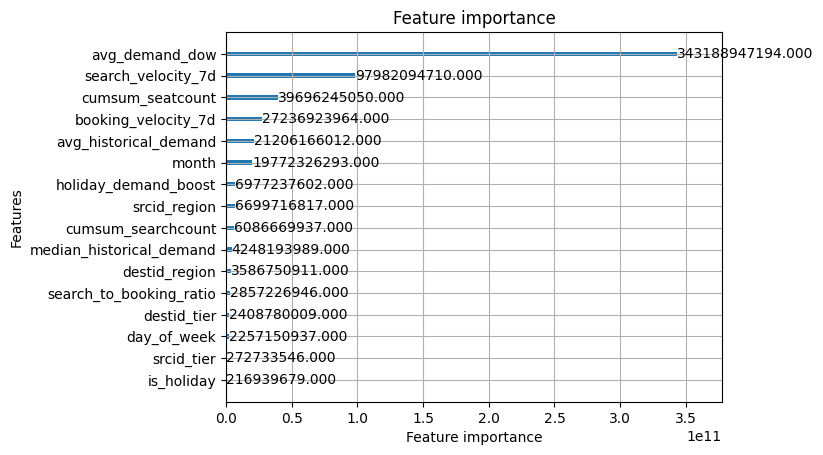

In [66]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()

In [58]:
def evaluate_model(model, X_val, y_val, feature_columns):
    """Evaluate model performance and generate diagnostics"""

    print("\nEvaluating model...")

    # Generate predictions
    val_preds = model.predict(X_val)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    mae = mean_absolute_error(y_val, val_preds)
    r2 = r2_score(y_val, val_preds)

    print(f"\nValidation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    feat_imp = pd.Series(model.feature_importances_, index=feature_columns)
    feat_imp.nlargest(15).sort_values().plot(kind='barh')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_val, y=val_preds, scatter_kws={'alpha':0.3})
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    plt.show()

    # Plot error distribution
    errors = y_val - val_preds
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Error Distribution')
    plt.tight_layout()
    plt.savefig('error_distribution.png')
    plt.show()


Evaluating model...

Validation Metrics:
RMSE: 550.7389
MAE: 389.8412
R²: 0.8138


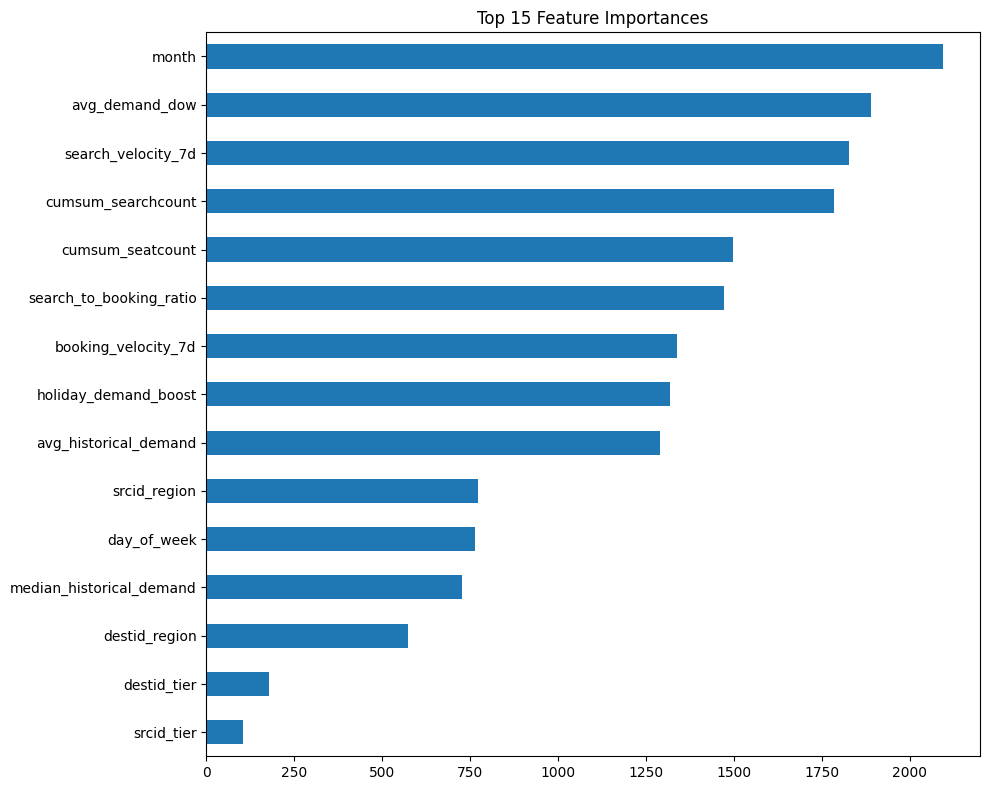

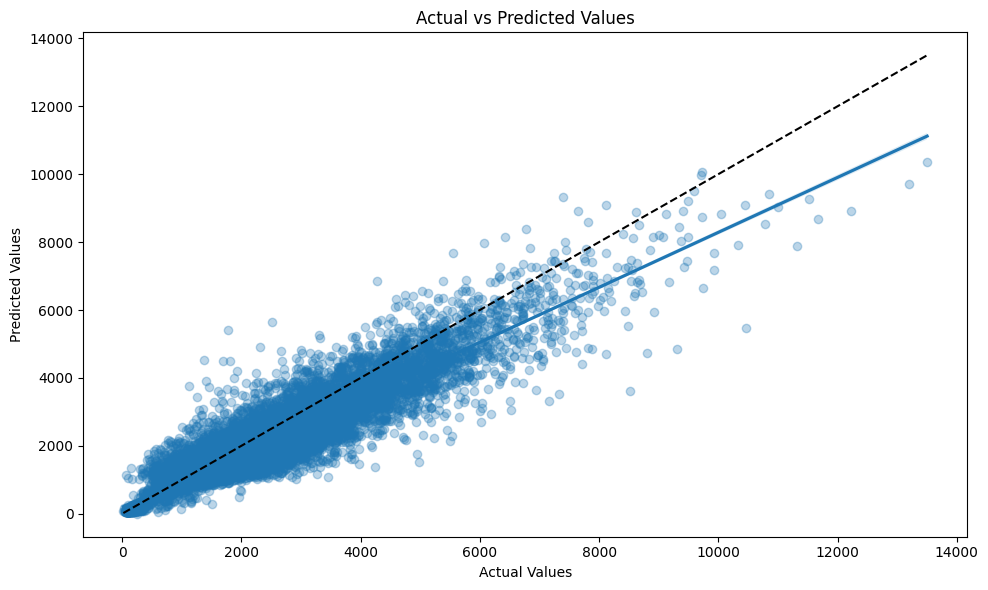

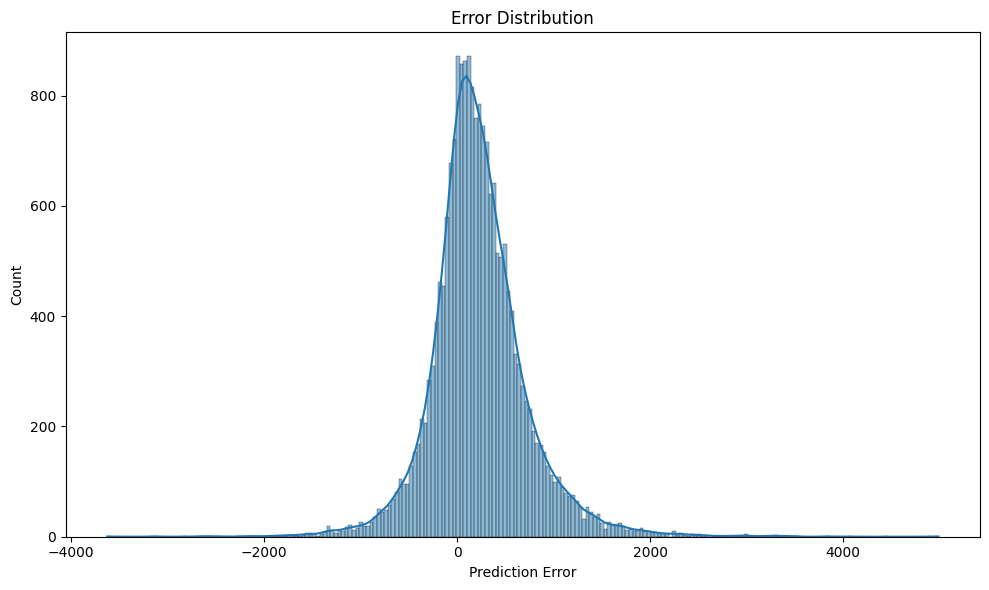

In [59]:
evaluate_model(model, X_val, y_val, X_val.columns.tolist())